In [1]:
!pip install findspark

You should consider upgrading via the 'd:\anaconda-3\python.exe -m pip install --upgrade pip' command.


In [1]:
import findspark

In [2]:
findspark.find()

'C:\\spark-3.0.3-bin-hadoop3.2'

In [3]:
findspark.init()

In [4]:
from pyspark import SparkContext

In [5]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [6]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (6,4)})
rcParams['figure.figsize'] = 6,4

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [9]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("practice-pyspark")
         .getOrCreate())

In [10]:
spark

In [11]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=practice-pyspark>

In [12]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [13]:
MUSIC_TRACKS_DATA = 'data/tracks.csv'
CUSTOMER_DATA     = 'data/cust.csv'
CLICKS_DATA       = 'data/clicks.csv'

In [14]:
# define the schema, corresponding to a line in the csv data file for music
music_schema = StructType([
    StructField('event_id', IntegerType(), nullable=True),
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('track_id', StringType(), nullable=True),
    StructField('datetime', StringType(), nullable=True),
    StructField('is_mobile', IntegerType(), nullable=True),
    StructField('zip', IntegerType(), nullable=True)]
  )

In [15]:
# define the schema, corresponding to a line in the csv data file for customer
cust_schema = StructType([
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('name', StringType(), nullable=True),
    StructField('gender', IntegerType(), nullable=True),
    StructField('address', StringType(), nullable=True),
    StructField('zip', IntegerType(), nullable=True),
    StructField('sign_date', StringType(), nullable=True),
    StructField('status', IntegerType(), nullable=True),
    StructField('level', IntegerType(), nullable=True),
    StructField('campaign', IntegerType(), nullable=True),
    StructField('lnkd_with_apps', IntegerType(), nullable=True)]
  )

In [16]:
# define the schema, corresponding to a line in the csv data file for ad click
click_schema = StructType([
    StructField('event_id', IntegerType(), nullable=True),
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('ad_clicked', StringType(), nullable=True),
    StructField('datetime', StringType(), nullable=True)]
  )

In [17]:
# Load data
music_df = spark.read.csv(path=MUSIC_TRACKS_DATA, schema=music_schema).cache()
music_df.createOrReplaceTempView("music")

cust_df = spark.read.csv(path=CUSTOMER_DATA, schema=cust_schema, header=True).cache()
cust_df.createOrReplaceTempView("cust")

click_df = spark.read.csv(path=CLICKS_DATA, schema=click_schema, header=False).cache()
click_df.createOrReplaceTempView("click")

In [18]:
# How many music data rows
music_df.count()

1000000

In [19]:
music_df.show(5)

+--------+-----------+--------+-------------------+---------+-----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|
+--------+-----------+--------+-------------------+---------+-----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|
+--------+-----------+--------+-------------------+---------+-----+
only showing top 5 rows



In [20]:
# How many customer data rows
cust_df.count()

5000

In [21]:
cust_df.show(5)

+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|customer_id|         name|gender|             address|  zip| sign_date|status|level|campaign|lnkd_with_apps|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|          0|Gregory Koval|     0|13004 Easy Cider ...|72132|06/04/2013|     1|    1|       1|             0|
|          1|Robert Gordon|     0|10497 Thunder Hic...|17307|07/27/2013|     1|    1|       1|             0|
|          2|Paula Peltier|     0|10084 Easy Gate Bend|66216|01/13/2013|     1|    0|       4|             1|
|          3|Francine Gray|     0|54845 Bent Pony H...|36690|07/11/2013|     1|    1|       1|             1|
|          4| David Garcia|     0|8551 Tawny Fox Villa|61377|09/09/2012|     1|    0|       1|             1|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
only showi

In [22]:
# How many ads click data rows
click_df.count()

65711

In [23]:
click_df.show(5)

+--------+-----------+--------------------+-------------------+
|event_id|customer_id|          ad_clicked|           datetime|
+--------+-----------+--------------------+-------------------+
|   76611|       2488|   ADV_FREE_REFERRAL|2014-12-25 05:08:59|
|  305706|       2476|ADV_DONATION_CHARITY|2014-11-26 22:24:21|
|  156074|       1307|   ADV_FREE_REFERRAL|2014-10-15 03:52:40|
|  192762|       1733|   ADV_LIKE_FACEBOOK|2014-10-20 14:55:08|
|   76106|          2|   ADV_LIKE_FACEBOOK|2014-11-19 00:22:13|
+--------+-----------+--------------------+-------------------+
only showing top 5 rows



In [24]:
hourly_music_df = music_df.withColumn('hour', F.hour('datetime')).cache()

In [25]:
hourly_music_df.show(5)

+--------+-----------+--------+-------------------+---------+-----+----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|
+--------+-----------+--------+-------------------+---------+-----+----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|
+--------+-----------+--------+-------------------+---------+-----+----+
only showing top 5 rows



In [26]:
hourly_music_df = (hourly_music_df
    .withColumn('night', F.when((col('hour') < 5) | (col('hour') >= 22), 1).otherwise(0))
    .withColumn('morn', F.when((col('hour') >= 5) & (col('hour') < 12), 1).otherwise(0))
    .withColumn('aft', F.when((col('hour') >= 12) & (col('hour') < 17), 1).otherwise(0))
    .withColumn('eve', F.when((col('hour') >= 17) & (col('hour') < 22), 1).otherwise(0))
    .cache())

In [27]:
hourly_music_df.filter('night == 1').count()

291516

In [28]:
cust_profile_df = (hourly_music_df.select(['customer_id', 'track_id', 'night', 'morn', 'aft', 'eve', 'is_mobile'])
     .groupBy('customer_id')
     .agg(F.countDistinct('track_id'), F.sum('night'), F.sum('morn'), F.sum('aft'), F.sum('eve'), F.sum('is_mobile'))).cache()

In [29]:
cust_profile_df.show(10)

+-----------+---------------+----------+---------+--------+--------+--------------+
|customer_id|count(track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+---------------+----------+---------+--------+--------+--------------+
|        148|            443|       149|      170|     109|     124|           476|
|        463|            306|       103|       99|      84|      76|           176|
|       1591|            171|        47|       64|      36|      40|            85|
|       2366|            143|        55|       46|      30|      25|           113|
|       4101|            100|        31|       28|      26|      22|            85|
|       1342|            173|        53|       60|      36|      42|           102|
|       2659|            119|        42|       43|      22|      22|            59|
|       1238|            191|        72|       64|      30|      46|           158|
|       4519|            103|        37|       30|      20|      20|        

In [30]:
spark.sql(
"""
SELECT  *, 
        HOUR(datetime) as hour, 
        CASE WHEN HOUR(datetime) < 5 OR HOUR(datetime) >= 22 THEN 1 ELSE 0 END AS night,
        CASE WHEN HOUR(datetime) >= 5 AND HOUR(datetime) < 12 THEN 1 ELSE 0 END AS morn,
        CASE WHEN HOUR(datetime) >= 12 AND HOUR(datetime) < 17 THEN 1 ELSE 0 END AS aft,
        CASE WHEN HOUR(datetime) >= 17 AND HOUR(datetime) < 22 THEN 1 ELSE 0 END AS eve
FROM music
""").show(10)

+--------+-----------+--------+-------------------+---------+-----+----+-----+----+---+---+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|night|morn|aft|eve|
+--------+-----------+--------+-------------------+---------+-----+----+-----+----+---+---+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|    1|   0|  0|  0|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|    0|   0|  0|  1|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|    0|   0|  1|  0|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|    1|   0|  0|  0|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|    0|   1|  0|  0|
|       5|       1811|       6|2014-11-18 02:00:48|        1|20115|   2|    1|   0|  0|  0|
|       6|       3644|      24|2014-12-12 15:24:02|        1|15330|  15|    0|   0|  1|  0|
|       7|        250|     726|2014-10-07 09:48:53|        0|33570|   9|    0|  

In [31]:
spark.sql(
"""
SELECT customer_id, COUNT(DISTINCT track_id), SUM(night), SUM(morn), SUM(aft), SUM(eve), SUM(is_mobile) 
FROM(
    SELECT  *, 
            HOUR(datetime) as hour, 
            CASE WHEN HOUR(datetime) < 5 OR HOUR(datetime) >= 22 THEN 1 ELSE 0 END AS night,
            CASE WHEN HOUR(datetime) >= 5 AND HOUR(datetime) < 12 THEN 1 ELSE 0 END AS morn,
            CASE WHEN HOUR(datetime) >= 12 AND HOUR(datetime) < 17 THEN 1 ELSE 0 END AS aft,
            CASE WHEN HOUR(datetime) >= 17 AND HOUR(datetime) < 22 THEN 1 ELSE 0 END AS eve
    FROM music)
GROUP BY customer_id
""").show(10)

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|        148|                     443|       149|      170|     109|     124|           476|
|        463|                     306|       103|       99|      84|      76|           176|
|       1591|                     171|        47|       64|      36|      40|            85|
|       2366|                     143|        55|       46|      30|      25|           113|
|       4101|                     100|        31|       28|      26|      22|            85|
|       1342|                     173|        53|       60|      36|      42|           102|
|       2659|                     119|        42|       43|      22|      22|            59|
|       1238|                     191|        72|       64|      30|  

In [32]:
# Referring to cust_profile_df from section 4.1.1 we can use the describe() function to get the summary statistics
cust_profile_df.select([c for c in cust_profile_df.columns if c not in ['customer_id']]).describe().show()

+-------+------------------+-----------------+----------------+-----------------+-----------------+------------------+
|summary|   count(track_id)|       sum(night)|       sum(morn)|         sum(aft)|         sum(eve)|    sum(is_mobile)|
+-------+------------------+-----------------+----------------+-----------------+-----------------+------------------+
|  count|              5000|             5000|            5000|             5000|             5000|              5000|
|   mean|           170.295|          58.3032|         58.2908|          41.6434|          41.7626|           121.553|
| stddev|117.04437556828793|67.27232404842705|67.3964412370437|47.87538247251274|48.01370329792189|148.79537090743347|
|    min|                68|               15|              16|                9|                9|                32|
|    max|              1617|             2139|            2007|             1460|             1480|              5093|
+-------+------------------+-----------------+--

In [33]:
# store the describe dataframe temporarily
summary_stats_df = cust_profile_df.select([c for c in cust_profile_df.columns if c not in ['customer_id']]).describe()

In [34]:
# loop over the column names and format
for col_name in summary_stats_df.columns:
    if col_name not in ['summary']:
        summary_stats_df = summary_stats_df.withColumn(col_name, F.format_number(col(col_name).cast('float'), 2))

In [35]:
summary_stats_df.show()

+-------+---------------+----------+---------+--------+--------+--------------+
|summary|count(track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-------+---------------+----------+---------+--------+--------+--------------+
|  count|       5,000.00|  5,000.00| 5,000.00|5,000.00|5,000.00|      5,000.00|
|   mean|         170.29|     58.30|    58.29|   41.64|   41.76|        121.55|
| stddev|         117.04|     67.27|    67.40|   47.88|   48.01|        148.80|
|    min|          68.00|     15.00|    16.00|    9.00|    9.00|         32.00|
|    max|       1,617.00|  2,139.00| 2,007.00|1,460.00|1,480.00|      5,093.00|
+-------+---------------+----------+---------+--------+--------+--------------+



In [36]:
# lets select only the original columns 
music_rdd = music_df.select('customer_id', 'track_id', 'datetime', 'is_mobile', 'zip').rdd.cache()

In [39]:
print(music_rdd.take(5))

[Row(customer_id=48, track_id='453', datetime='2014-10-23 03:26:20', is_mobile=0, zip=72132), Row(customer_id=1081, track_id='19', datetime='2014-10-15 18:32:14', is_mobile=1, zip=17307), Row(customer_id=532, track_id='36', datetime='2014-12-10 15:33:16', is_mobile=1, zip=66216), Row(customer_id=2641, track_id='822', datetime='2014-10-20 02:24:55', is_mobile=1, zip=36690), Row(customer_id=2251, track_id='338', datetime='2014-11-18 07:16:05', is_mobile=1, zip=61377)]


In [40]:
# Use customer_id as the key, we will later group by on this column
music_rdd.map(lambda record : (record.customer_id, record)).take(5)

[(48,
  Row(customer_id=48, track_id='453', datetime='2014-10-23 03:26:20', is_mobile=0, zip=72132)),
 (1081,
  Row(customer_id=1081, track_id='19', datetime='2014-10-15 18:32:14', is_mobile=1, zip=17307)),
 (532,
  Row(customer_id=532, track_id='36', datetime='2014-12-10 15:33:16', is_mobile=1, zip=66216)),
 (2641,
  Row(customer_id=2641, track_id='822', datetime='2014-10-20 02:24:55', is_mobile=1, zip=36690)),
 (2251,
  Row(customer_id=2251, track_id='338', datetime='2014-11-18 07:16:05', is_mobile=1, zip=61377))]

In [41]:
def compute_stats_byuser(tracks):
    mcount = morn = aft = eve = night = 0
    tracklist = []
    for t in tracks:
        custid, trackid, dtime, mobile, zip = t
        if trackid not in tracklist:
            tracklist.append(trackid)
        d, t = dtime.split(" ")
        hourofday = int(t.split(":")[0])
        mcount += mobile
        if (hourofday < 5):
            night += 1
        elif (hourofday < 12):
            morn += 1
        elif (hourofday < 17):
            aft += 1
        elif (hourofday < 22):
            eve += 1
        else:
            night += 1
    return len(tracklist), morn, aft, eve, night, mcount

In [42]:
cust_profile_rdd = (music_rdd.map(lambda record : (record.customer_id, record))
                    .groupByKey().mapValues(lambda tracks: compute_stats_byuser(tracks)))

In [43]:
cust_profile_rdd.cache()

PythonRDD[118] at RDD at PythonRDD.scala:53

In [44]:
cust_profile_rdd.take(10)

[(48, (696, 310, 217, 223, 277, 503)),
 (2064, (137, 38, 32, 39, 36, 69)),
 (536, (272, 84, 67, 60, 101, 152)),
 (24, (853, 433, 275, 287, 433, 1192)),
 (392, (314, 112, 80, 76, 102, 265)),
 (1432, (190, 55, 36, 43, 66, 97)),
 (744, (240, 75, 56, 61, 79, 232)),
 (4840, (100, 30, 22, 17, 39, 60)),
 (2160, (151, 61, 23, 29, 45, 131)),
 (472, (302, 111, 76, 79, 88, 165))]

In [45]:
cust_profile_rdd.filter(lambda record: record[0] == 48).take(1)

[(48, (696, 310, 217, 223, 277, 503))]

In [46]:
cust_profile_df.filter(col('customer_id') == 48).show()

+-----------+---------------+----------+---------+--------+--------+--------------+
|customer_id|count(track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+---------------+----------+---------+--------+--------+--------------+
|         48|            696|       277|      310|     217|     223|           503|
+-----------+---------------+----------+---------+--------+--------+--------------+



In [47]:
from pyspark.mllib.stat import Statistics 

In [48]:
# compute aggregate stats for entire track history  
summary_stats_ml = Statistics.colStats(cust_profile_rdd.map(lambda x: x[1]))  

In [49]:
summary_stats_ml.count()

5000

In [50]:
summary_stats_ml.mean()

array([170.295 ,  58.2908,  41.6434,  41.7626,  58.3032, 121.553 ])

In [51]:
summary_stats_ml.max()

array([1617., 2007., 1460., 1480., 2139., 5093.])

In [52]:
summary_stats_ml.min()

array([68., 16.,  9.,  9., 15., 32.])

In [53]:
music_df.select('event_id', 'customer_id', 'track_id', 'datetime', 'is_mobile', 'zip', F.hour('datetime').alias('hour')).show(10)

+--------+-----------+--------+-------------------+---------+-----+----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|
+--------+-----------+--------+-------------------+---------+-----+----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|
|       5|       1811|       6|2014-11-18 02:00:48|        1|20115|   2|
|       6|       3644|      24|2014-12-12 15:24:02|        1|15330|  15|
|       7|        250|     726|2014-10-07 09:48:53|        0|33570|   9|
|       8|       1782|     442|2014-12-30 15:27:31|        1|41240|  15|
|       9|       2932|     775|2014-11-12 07:45:55|        0|63565|   7|
+--------+-----------+--------+-------------------+

In [54]:
# Create the hour buckets
(music_df
 .select('event_id', 'customer_id', 'track_id', 'datetime', 'is_mobile', 'zip', 
         F.hour('datetime').alias('hour'),
         F.when((F.hour('datetime') < 5) | (F.hour('datetime') >= 22), F.lit('night'))
          .when((F.hour('datetime') >= 5) & (F.hour('datetime') < 12), F.lit('morn'))
          .when((F.hour('datetime') >= 12) & (F.hour('datetime') < 17), F.lit('aft'))
          .when((F.hour('datetime') >= 17) & (F.hour('datetime') < 22), F.lit('eve'))
          .alias('bucket')) 
).show(10)

+--------+-----------+--------+-------------------+---------+-----+----+------+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|bucket|
+--------+-----------+--------+-------------------+---------+-----+----+------+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3| night|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|   eve|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|   aft|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2| night|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|  morn|
|       5|       1811|       6|2014-11-18 02:00:48|        1|20115|   2| night|
|       6|       3644|      24|2014-12-12 15:24:02|        1|15330|  15|   aft|
|       7|        250|     726|2014-10-07 09:48:53|        0|33570|   9|  morn|
|       8|       1782|     442|2014-12-30 15:27:31|        1|41240|  15|   aft|
|       9|       2932|     775|2014-11-1

In [55]:
# Create the hour buckets and then pivot on the hour buckets
hourly_pivot_df = (music_df.select('event_id', 'customer_id', 'track_id', 'datetime', 'is_mobile', 'zip', 
             F.hour('datetime').alias('hour'),
             F.when((F.hour('datetime') < 5) | (F.hour('datetime') >= 22), F.lit('night'))
              .when((F.hour('datetime') >= 5) & (F.hour('datetime') < 12), F.lit('morn'))
              .when((F.hour('datetime') >= 12) & (F.hour('datetime') < 17), F.lit('aft'))
              .when((F.hour('datetime') >= 17) & (F.hour('datetime') < 22), F.lit('eve'))
              .alias('bucket'))
              .select('customer_id', 'bucket')
              .groupBy('customer_id')
              .pivot('bucket', ['night', 'morn', 'aft', 'eve'])
              .agg(F.count('bucket'))
           ).cache()

In [56]:
hourly_pivot_df.show(10)

+-----------+-----+----+---+---+
|customer_id|night|morn|aft|eve|
+-----------+-----+----+---+---+
|        471|   84|  96| 60| 73|
|       3175|   35|  28| 25| 21|
|        833|   70|  75| 48| 63|
|       1088|   69|  62| 41| 46|
|        463|  103|  99| 84| 76|
|       1238|   72|  64| 30| 46|
|       1645|   55|  42| 54| 35|
|       1342|   53|  60| 36| 42|
|       1959|   42|  43| 34| 24|
|       2366|   55|  46| 30| 25|
+-----------+-----+----+---+---+
only showing top 10 rows



In [57]:
hourly_pivot_df.filter(col('customer_id') == 48).show()

+-----------+-----+----+---+---+
|customer_id|night|morn|aft|eve|
+-----------+-----+----+---+---+
|         48|  277| 310|217|223|
+-----------+-----+----+---+---+



In [58]:
cust_profile_df.filter(col('customer_id') == 48).show()

+-----------+---------------+----------+---------+--------+--------+--------------+
|customer_id|count(track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+---------------+----------+---------+--------+--------+--------------+
|         48|            696|       277|      310|     217|     223|           503|
+-----------+---------------+----------+---------+--------+--------+--------------+



In [59]:
tracks_summary_df = (music_df
 .select('customer_id', 'track_id', 'is_mobile')
 .groupBy('customer_id')
 .agg(F.countDistinct('track_id'), F.sum('is_mobile'))
).cache()

In [60]:
tracks_summary_df.show(10)

+-----------+---------------+--------------+
|customer_id|count(track_id)|sum(is_mobile)|
+-----------+---------------+--------------+
|        148|            443|           476|
|        463|            306|           176|
|       1591|            171|            85|
|       2366|            143|           113|
|       4101|            100|            85|
|       1342|            173|           102|
|       2659|            119|            59|
|       1238|            191|           158|
|       4519|            103|            54|
|       1580|            162|           134|
+-----------+---------------+--------------+
only showing top 10 rows



In [61]:
(tracks_summary_df
 .join(hourly_pivot_df, on='customer_id', how='inner')
 .select('customer_id', 'count(DISTINCT track_id)', 
         col('night').alias('sum(night)'), 
         col('morn').alias('sum(morn)'), 
         col('aft').alias('sum(aft)'), 
         col('eve').alias('sum(eve)'),
         'sum(is_mobile)')
 .filter(col('customer_id') == 48)
).show()

AnalysisException: cannot resolve '`count(DISTINCT track_id)`' given input columns: [aft, count(track_id), customer_id, eve, morn, night, sum(is_mobile)];;
'Project [customer_id#1, 'count(DISTINCT track_id), night#3982L AS sum(night)#11103L, morn#3983L AS sum(morn)#11104L, aft#3984L AS sum(aft)#11105L, eve#3985L AS sum(eve)#11106L, sum(is_mobile)#10916L]
+- Project [customer_id#1, count(track_id)#10915L, sum(is_mobile)#10916L, night#3982L, morn#3983L, aft#3984L, eve#3985L]
   +- Join Inner, (customer_id#1 = customer_id#11091)
      :- Aggregate [customer_id#1], [customer_id#1, count(distinct track_id#2) AS count(track_id)#10915L, sum(cast(is_mobile#4 as bigint)) AS sum(is_mobile)#10916L]
      :  +- Project [customer_id#1, track_id#2, is_mobile#4]
      :     +- Relation[event_id#0,customer_id#1,track_id#2,datetime#3,is_mobile#4,zip#5] csv
      +- Project [customer_id#11091, __pivot_count(`bucket`) AS `count(``bucket``)`#3981[0] AS night#3982L, __pivot_count(`bucket`) AS `count(``bucket``)`#3981[1] AS morn#3983L, __pivot_count(`bucket`) AS `count(``bucket``)`#3981[2] AS aft#3984L, __pivot_count(`bucket`) AS `count(``bucket``)`#3981[3] AS eve#3985L]
         +- Aggregate [customer_id#11091], [customer_id#11091, pivotfirst(bucket#3956, count(`bucket`)#3971L, night, morn, aft, eve, 0, 0) AS __pivot_count(`bucket`) AS `count(``bucket``)`#3981]
            +- Aggregate [customer_id#11091, bucket#3956], [customer_id#11091, bucket#3956, count(bucket#3956) AS count(`bucket`)#3971L]
               +- Project [customer_id#11091, bucket#3956]
                  +- Project [event_id#11090, customer_id#11091, track_id#11092, datetime#11093, is_mobile#11094, zip#11095, hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) AS hour#3955, CASE WHEN ((hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) < 5) OR (hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) >= 22)) THEN night WHEN ((hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) >= 5) AND (hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) < 12)) THEN morn WHEN ((hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) >= 12) AND (hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) < 17)) THEN aft WHEN ((hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) >= 17) AND (hour(cast(datetime#11093 as timestamp), Some(America/Chicago)) < 22)) THEN eve END AS bucket#3956]
                     +- Relation[event_id#11090,customer_id#11091,track_id#11092,datetime#11093,is_mobile#11094,zip#11095] csv


In [62]:
# Create the hour buckets and then pivot on the hour buckets
hourly_pivot_df = (music_df.select('event_id', 'customer_id', 'track_id', 'datetime', 'is_mobile', 'zip', 
             F.hour('datetime').alias('hour'),
             F.when((F.hour('datetime') < 5) | (F.hour('datetime') >= 22), F.lit('night'))
              .when((F.hour('datetime') >= 5) & (F.hour('datetime') < 12), F.lit('morn'))
              .when((F.hour('datetime') >= 12) & (F.hour('datetime') < 17), F.lit('aft'))
              .when((F.hour('datetime') >= 17) & (F.hour('datetime') < 22), F.lit('eve'))
              .alias('bucket'))
              .select('customer_id', 'bucket')
              .groupBy('customer_id')
              .pivot('bucket', ['night', 'morn', 'aft', 'eve'])
              .agg(F.count('bucket'))
           ).cache()

In [63]:
hourly_pivot_df.show(10)

+-----------+-----+----+---+---+
|customer_id|night|morn|aft|eve|
+-----------+-----+----+---+---+
|        471|   84|  96| 60| 73|
|       3175|   35|  28| 25| 21|
|        833|   70|  75| 48| 63|
|       1088|   69|  62| 41| 46|
|        463|  103|  99| 84| 76|
|       1238|   72|  64| 30| 46|
|       1645|   55|  42| 54| 35|
|       1342|   53|  60| 36| 42|
|       1959|   42|  43| 34| 24|
|       2366|   55|  46| 30| 25|
+-----------+-----+----+---+---+
only showing top 10 rows



In [64]:
(hourly_pivot_df
    .select('customer_id', 
        F.array(
            F.struct(F.lit('night').alias('bucket'), col('night').alias('count')), 
            F.struct(F.lit('morn').alias('bucket'), col('morn').alias('count')),
            F.struct(F.lit('aft').alias('bucket'), col('aft').alias('count')),
            F.struct(F.lit('eve').alias('bucket'), col('eve').alias('count'))
          ).alias('array_of_struct_bucket_count')
        )).show(10, truncate=False)

+-----------+------------------------------------------------+
|customer_id|array_of_struct_bucket_count                    |
+-----------+------------------------------------------------+
|471        |[[night, 84], [morn, 96], [aft, 60], [eve, 73]] |
|3175       |[[night, 35], [morn, 28], [aft, 25], [eve, 21]] |
|833        |[[night, 70], [morn, 75], [aft, 48], [eve, 63]] |
|1088       |[[night, 69], [morn, 62], [aft, 41], [eve, 46]] |
|463        |[[night, 103], [morn, 99], [aft, 84], [eve, 76]]|
|1238       |[[night, 72], [morn, 64], [aft, 30], [eve, 46]] |
|1645       |[[night, 55], [morn, 42], [aft, 54], [eve, 35]] |
|1342       |[[night, 53], [morn, 60], [aft, 36], [eve, 42]] |
|1959       |[[night, 42], [morn, 43], [aft, 34], [eve, 24]] |
|2366       |[[night, 55], [morn, 46], [aft, 30], [eve, 25]] |
+-----------+------------------------------------------------+
only showing top 10 rows



In [65]:
(hourly_pivot_df
    .select('customer_id',    
        F.explode(
            F.array(
                F.struct(F.lit('night').alias('bucket'), col('night').alias('count')), 
                F.struct(F.lit('morn').alias('bucket'), col('morn').alias('count')),
                F.struct(F.lit('aft').alias('bucket'), col('aft').alias('count')),
                F.struct(F.lit('eve').alias('bucket'), col('eve').alias('count'))
            )
          ).alias('exploded_struct_bucket_count')
        )).show(10, truncate=False)

+-----------+----------------------------+
|customer_id|exploded_struct_bucket_count|
+-----------+----------------------------+
|471        |[night, 84]                 |
|471        |[morn, 96]                  |
|471        |[aft, 60]                   |
|471        |[eve, 73]                   |
|3175       |[night, 35]                 |
|3175       |[morn, 28]                  |
|3175       |[aft, 25]                   |
|3175       |[eve, 21]                   |
|833        |[night, 70]                 |
|833        |[morn, 75]                  |
+-----------+----------------------------+
only showing top 10 rows



In [66]:
(hourly_pivot_df
    .withColumn('exploded_struct_bucket_count',    
        F.explode(
            F.array(
                F.struct(F.lit('night').alias('bucket'), col('night').alias('count')), 
                F.struct(F.lit('morn').alias('bucket'), col('morn').alias('count'))
            )
          )         
        )
     .selectExpr('customer_id', 'exploded_struct_bucket_count.bucket as bucket', 'exploded_struct_bucket_count.count as count')
).show(10, truncate=False)

+-----------+------+-----+
|customer_id|bucket|count|
+-----------+------+-----+
|471        |night |84   |
|471        |morn  |96   |
|3175       |night |35   |
|3175       |morn  |28   |
|833        |night |70   |
|833        |morn  |75   |
|1088       |night |69   |
|1088       |morn  |62   |
|463        |night |103  |
|463        |morn  |99   |
+-----------+------+-----+
only showing top 10 rows



In [67]:
hourly_pivot_df.unpersist()

DataFrame[customer_id: int, night: bigint, morn: bigint, aft: bigint, eve: bigint]

In [68]:
cust_df.show(5)

+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|customer_id|         name|gender|             address|  zip| sign_date|status|level|campaign|lnkd_with_apps|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|          0|Gregory Koval|     0|13004 Easy Cider ...|72132|06/04/2013|     1|    1|       1|             0|
|          1|Robert Gordon|     0|10497 Thunder Hic...|17307|07/27/2013|     1|    1|       1|             0|
|          2|Paula Peltier|     0|10084 Easy Gate Bend|66216|01/13/2013|     1|    0|       4|             1|
|          3|Francine Gray|     0|54845 Bent Pony H...|36690|07/11/2013|     1|    1|       1|             1|
|          4| David Garcia|     0|8551 Tawny Fox Villa|61377|09/09/2012|     1|    0|       1|             1|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
only showi

In [69]:
# Map from level number to actual level string
level_map = {0:"Free", 1:"Silver", 2:"Gold"}

# Define a udf
udfIndexTolevel = udf(lambda x: level_map[x], StringType())

In [70]:
result_df = (cust_df.join(cust_profile_df, on='customer_id', how='inner')
                     .select([udfIndexTolevel('level').alias('level'), 'sum(night)', 'sum(morn)', 'sum(aft)', 'sum(eve)'])
                     .groupBy('level')
                     .agg(F.avg('sum(aft)').alias('Afternoon'), 
                          F.avg('sum(eve)').alias('Evening'), 
                          F.avg('sum(morn)').alias('Morning'), 
                          F.avg('sum(night)').alias("Night")))

In [71]:
result_df.cache().show()

+------+------------------+------------------+-----------------+------------------+
| level|         Afternoon|           Evening|          Morning|             Night|
+------+------------------+------------------+-----------------+------------------+
|Silver| 42.12979890310786|42.409506398537474|59.01401584399756| 59.16209628275442|
|  Gold|39.868173258003765| 40.22975517890772|56.35969868173258|55.685499058380415|
|  Free|  41.6944837340877|41.675035360678926|58.23373408769449|  58.2963224893918|
+------+------------------+------------------+-----------------+------------------+



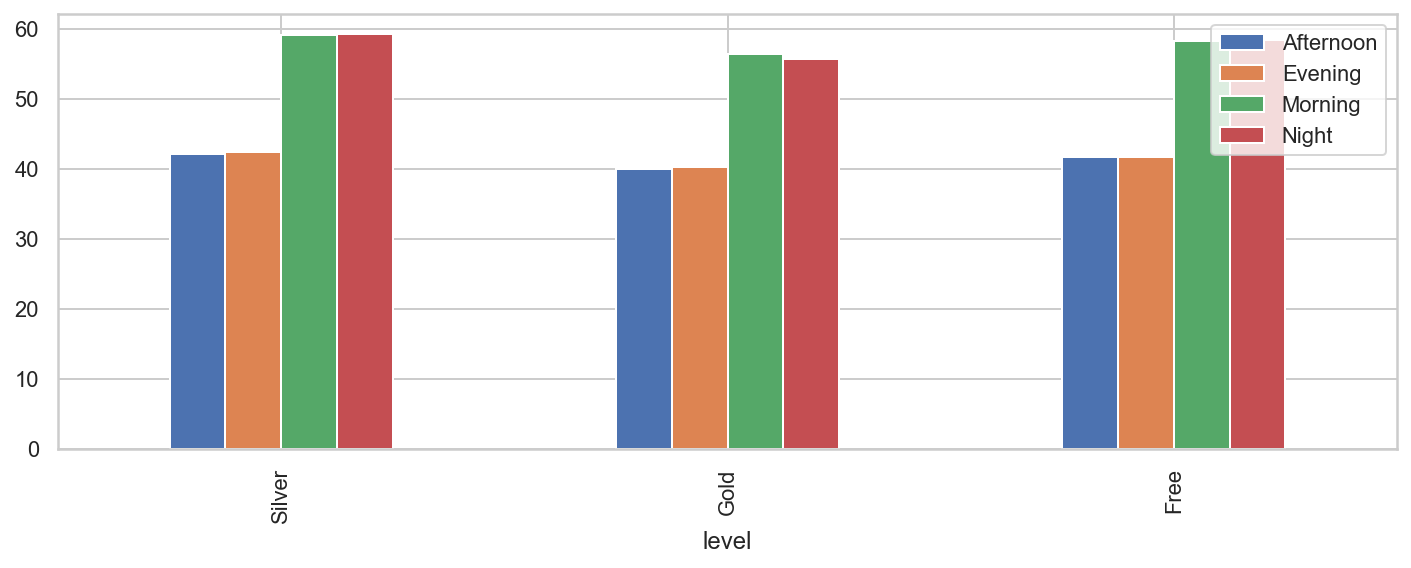

In [72]:
result_df.toPandas().plot.bar(x='level', figsize=(12, 4));

In [73]:
result_df.unpersist()

DataFrame[level: string, Afternoon: double, Evening: double, Morning: double, Night: double]

In [74]:
result_df = (cust_df.select(['level', (F.when(col('gender') == 0, "Male").otherwise("Female")).alias('gender')])
                 .groupBy('level')
                 .pivot('gender')
                 .count()
                 .orderBy('level', ascending=False))

In [75]:
result_df.cache().show()

+-----+------+----+
|level|Female|Male|
+-----+------+----+
|    2|   201| 330|
|    1|   670| 971|
|    0|  1145|1683|
+-----+------+----+



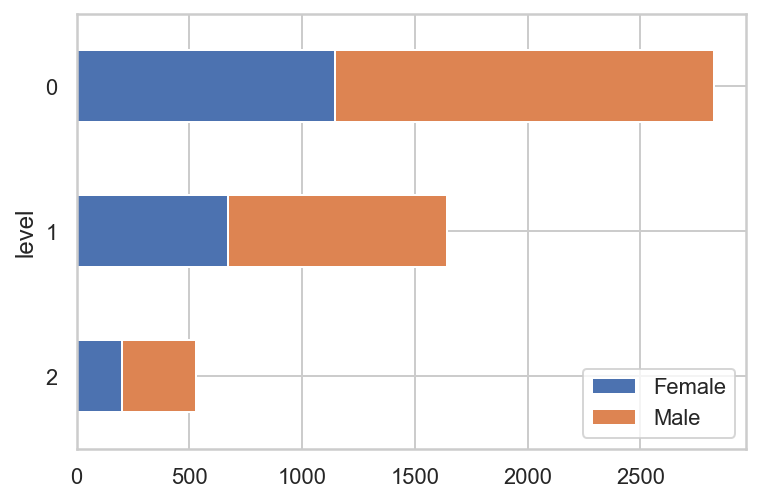

In [76]:
result_df.toPandas().set_index('level').plot.barh(stacked=True);

In [77]:
result_df.unpersist()

DataFrame[level: int, Female: bigint, Male: bigint]

In [78]:
result_df = cust_df.groupBy('zip').count().orderBy('count', ascending=False).limit(10)

In [79]:
result_df.cache().show()

+-----+-----+
|  zip|count|
+-----+-----+
| 5341|    4|
|80821|    4|
|71458|    3|
|31409|    3|
|70446|    3|
|20098|    3|
|80459|    3|
|57445|    3|
|78754|    3|
|47577|    3|
+-----+-----+



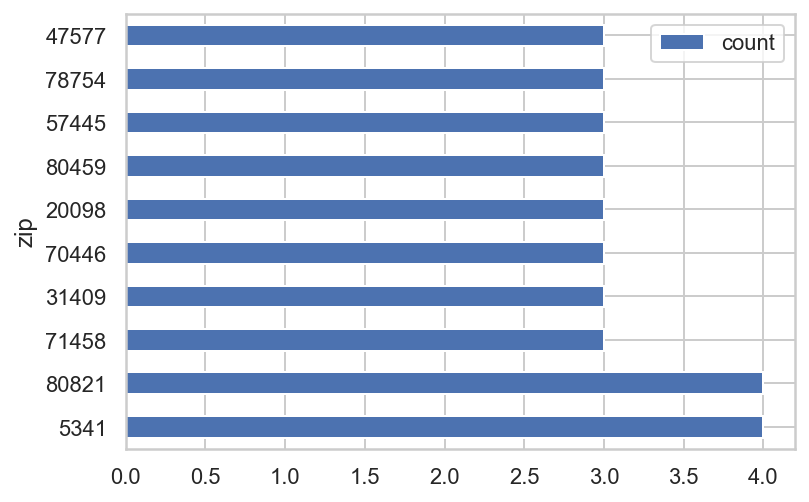

In [80]:
result_df.toPandas().plot.barh(x='zip');

In [81]:
result_df.unpersist()

DataFrame[zip: int, count: bigint]

In [82]:
# Map from campaign number to actual campaign description
campaign_map = {0:"None", 1:"30DaysFree", 2:"SuperBowl",  3:"RetailStore", 4:"WebOffer"}

# Define a udf
udfIndexToCampaign = udf(lambda x: campaign_map[x], StringType())

In [83]:
result_df = (cust_df.select(udfIndexToCampaign("campaign").alias("campaign"))
                 .groupBy('campaign')
                 .count()
                 .orderBy('count', ascending=True))

In [84]:
result_df.cache().show()

+-----------+-----+
|   campaign|count|
+-----------+-----+
|  SuperBowl|  240|
|RetailStore|  489|
|       None|  608|
|   WebOffer|  750|
| 30DaysFree| 2913|
+-----------+-----+



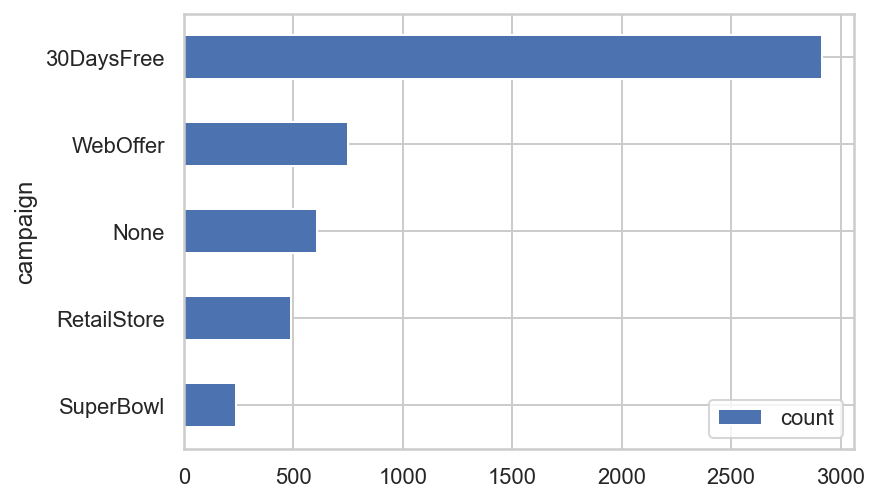

In [85]:
result_df.toPandas().plot.barh(x='campaign');

In [86]:
result_df.unpersist()

DataFrame[campaign: string, count: bigint]

In [87]:
result_df = (music_df.select(['customer_id', 'track_id'])
                            .groupBy('customer_id')
                            .agg(F.countDistinct('track_id').alias('unique_track_count'))
                            .join(cust_df, on='customer_id', how='inner')
                            .select([udfIndexTolevel('level').alias('level'), 'unique_track_count'])
                            .groupBy('level')
                            .agg(F.avg('unique_track_count').alias('avg_unique_track_count')))

In [88]:
result_df.cache().show()

+------+----------------------+
| level|avg_unique_track_count|
+------+----------------------+
|Silver|     170.2772699573431|
|  Gold|    166.85310734463278|
|  Free|     170.9515558698727|
+------+----------------------+



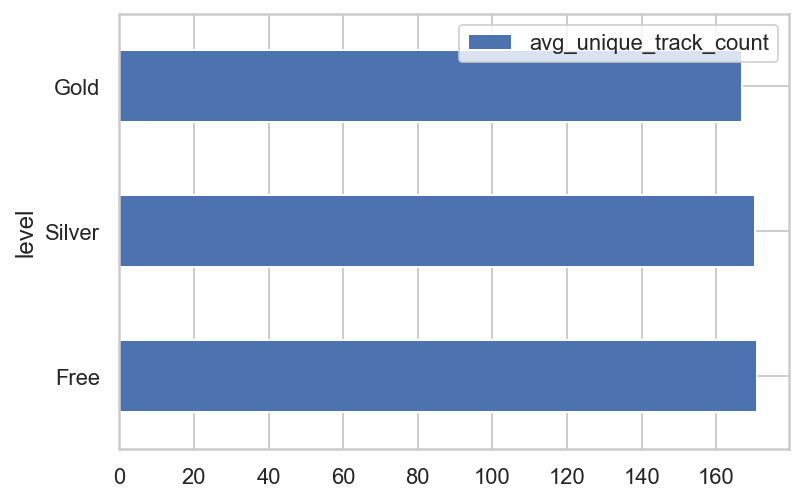

In [89]:
result_df.toPandas().sort_values(by='avg_unique_track_count', ascending=False).plot.barh(x='level');

In [90]:
result_df.unpersist()

DataFrame[level: string, avg_unique_track_count: double]

In [91]:
result_df = (music_df.select(['customer_id', 'track_id'])
                            .filter(col('is_mobile') == 1)
                            .groupBy('customer_id')
                            .count()
                            .withColumnRenamed('count', 'mobile_track_count')
                            .join(cust_df, on='customer_id', how='inner')
                            .select([udfIndexTolevel('level').alias('level'), 'mobile_track_count'])
                            .groupBy('level')
                            .agg(F.avg('mobile_track_count').alias('avg_mobile_track_count'))
                            .orderBy('avg_mobile_track_count'))

In [92]:
result_df.cache().show()

+------+----------------------+
| level|avg_mobile_track_count|
+------+----------------------+
|  Free|    100.01308345120226|
|Silver|     146.1614868982328|
|  Gold|    160.22033898305085|
+------+----------------------+



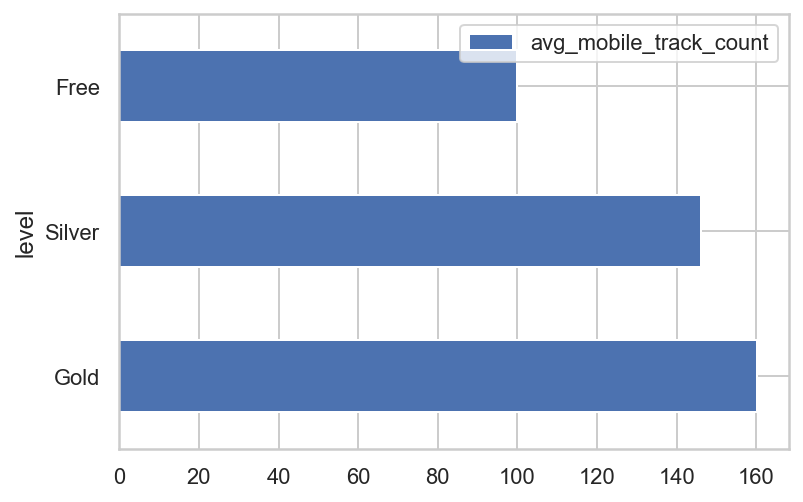

In [93]:
result_df.toPandas().sort_values(by='avg_mobile_track_count', ascending=False).plot.barh(x='level');

In [94]:
result_df.unpersist()

DataFrame[level: string, avg_mobile_track_count: double]

In [95]:
music_df.unpersist()
cust_df.unpersist()
click_df.unpersist()

DataFrame[event_id: int, customer_id: int, track_id: string, datetime: string, is_mobile: int, zip: int]

DataFrame[customer_id: int, name: string, gender: int, address: string, zip: int, sign_date: string, status: int, level: int, campaign: int, lnkd_with_apps: int]

DataFrame[event_id: int, customer_id: int, ad_clicked: string, datetime: string]

In [96]:
spark.stop()